<a href="https://colab.research.google.com/github/nambiar/MachineLearning/blob/master/Session9/Session9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -I scipy==1.2.*

     |████████████████████████████████| 24.8MB 1.4MB/s 
     |████████████████████████████████| 20.2MB 159kB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [1]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Add, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.datasets import mnist
#importing image normalisation class
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

#!pip install scipy==1.1.0 --user #doing this to enable vis.visualisation
from keras.preprocessing.image import load_img, img_to_array

Using TensorFlow backend.


Learning regarding the GradCam and how it can be incorporated

Class Activation Maps: 
Where the object is or localization

> As image moves through CNN it shrinks and through ReLU activation we see that the pixel is either 0 or 1, Each feature has a representation in the image


> In that sense beofr we do a GAP which gets a positive value for that feature at the last CONV layer we have this feature in one of the pixels
If we multiply 





Usage of ImageDataGenerator class for Image normalisation
Load the dataset, configure the class, calculate image properties ,fit the model using generator & evaluate generator
pixel scaling using Imagedate generator class, Pixel Normalization, Pixel Centering, pixel standarisation
create and configure the data generator


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)
print('Train', X_train.min(), X_train.max(), X_train.mean(), X_train.std())
print('Test', X_test.min(), X_test.max(), X_test.mean(), X_test.std())


11493376/11490434 [==============================] - 2s 0us/step
Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)
Train 0 255 33.318421449829934 78.56748998339798
Test 0 255 33.791224489795916 79.17246322228644


(60000, 28, 28)


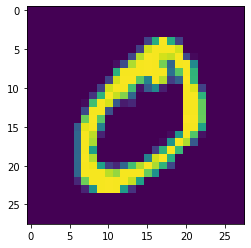

In [3]:
print (X_train.shape)
from matplotlib import pyplot as plt
%matplotlib inline
plt.imshow(X_train[1])


In [4]:
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)
print (X_train.shape)
plt.figure(figsize=[5,5])


           




(60000, 28, 28, 1)


<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

(28, 28, 1)


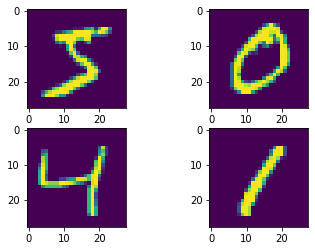

In [5]:
X_gradcam_image_1 = X_train[0,:,:,:]
X_gradcam_image_2 = X_train[1,:,:,:]
X_gradcam_image_3 = X_train[2,:,:,:]
X_gradcam_image_4 = X_train[3,:,:,:]
print(X_gradcam_image_2.shape)
%matplotlib inline

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(X_gradcam_image_1[:,:,0])
axarr[0,1].imshow(X_gradcam_image_2[:,:,0])
axarr[1,0].imshow(X_gradcam_image_3[:,:,0])
axarr[1,1].imshow(X_gradcam_image_4[:,:,0])


In [0]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
#X_train /= 255
#X_test /= 255

In [7]:
# Find the unique numbers from the train labels
classes = np.unique(y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)
y_train[:10]
plt
Y_train = np_utils.to_categorical(y_train)
Y_test = np_utils.to_categorical(y_test)
print('Original label:', y_train[0])
print('After conversion to one-hot:', Y_train[0])

Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]
Original label: 5
After conversion to one-hot: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [8]:
Y_train[:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [10]:
# confirm scale of pixels
print('Train min=%.3f, max=%.3f' % (X_train.min(), X_train.max()))
print('Test min=%.3f, max=%.3f' % (X_test.min(), X_test.max()))
#Rescaling argument to a ratio by which each pixel can be multiplied to achieve [1 -255] range so 1/255.
# create generator with rescaling factor(1.0/255.0 = 0.003921568627451)
imagenormalize = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True,preprocessing_function=get_random_eraser(v_l=0, v_h=1))
# calculate the mean on the training dataset
print(X_train.shape)
imagenormalize.fit(X_train)
print('Data Generator mean=%.3f, std=%.3f' % (imagenormalize.mean, imagenormalize.std))
#iterators for using the normalisation on all the images in test and train datasets with epoch's
X_train_iterator = imagenormalize.flow(X_train, Y_train, batch_size=64)
X_test_iterator = imagenormalize.flow(X_test, Y_test, batch_size=64)
#confimring normalisation works


print('Batches train=%d, test=%d' % (len(X_train_iterator), len(X_test_iterator)))
# confirm the scaling works
#test_trainX, test_trainY = X_train_iterator.next()
#print('Batch shape=%s, min=%.3f, max=%.3f, mean=%.3f, std=%.3f' % (test_trainX.shape, test_trainX.min(), test_trainX.max(),test_trainX.mean(), test_trainX.std()))
# demonstrate effect on entire training dataset
#iterator = imagenormalize.flow(X_train, Y_train, batch_size=len(X_train), shuffle=False)
# get a batch
#test_trainX, test_trainY = X_train_iterator.next()
# pixel stats in the batch
#print(test_trainX.shape, test_trainX.mean(), test_trainX.std())
#Also adding the  l2 regularisation it reduces the accuracy from

Train min=0.000, max=255.000
Test min=0.000, max=255.000
(60000, 28, 28, 1)
Data Generator mean=33.318, std=78.567
Batches train=938, test=157


In [11]:
from keras.layers import Activation
model = Sequential()

 
model.add(Convolution2D(16, 3, 3, activation='relu', input_shape=(28,28,1),kernel_regularizer=regularizers.l2(0.00001))) #26
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Convolution2D(32, 3, 3, activation='relu',kernel_regularizer=regularizers.l2(0.00001))) #24
model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Convolution2D(10, 1, 1, activation='relu',kernel_regularizer=regularizers.l2(0.00001))) #22

model.add(MaxPooling2D(pool_size=(2, 2)))#11

model.add(Convolution2D(16, 3, 3, activation='relu',kernel_regularizer=regularizers.l2(0.00001)))#9
model.add(BatchNormalization())
model.add(Dropout(0.1))


model.add(Convolution2D(16, 3, 3, activation='relu',kernel_regularizer=regularizers.l2(0.00001)))#7
model.add(BatchNormalization())
model.add(Dropout(0.1))


model.add(Convolution2D(16, 3, 3, activation='relu',kernel_regularizer=regularizers.l2(0.00001)))#5
model.add(BatchNormalization())
model.add(Dropout(0.1))


model.add(Convolution2D(16, 3, 3, activation='relu',kernel_regularizer=regularizers.l2(0.00001)))#3
model.add(BatchNormalization())
model.add(Dropout(0.1))


model.add(Convolution2D(10, 4, 4,kernel_regularizer=regularizers.l2(0.00001)))
model.add(BatchNormalization())
model.add(Dropout(0.1))


model.add(Flatten())
model.add(Activation('softmax'))


model.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu", input_shape=(28, 28, 1..., kernel_regularizer=<keras.reg...)`
  """







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", kernel_regularizer=<keras.reg...)`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1), activation="relu", kernel_regularizer=<keras.reg...)`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu", kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu", kernel_regularizer=<keras.reg...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), activation="relu",

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 16)        160       
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 16)        64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 26, 26, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 10)       



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/40

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.
938/938 [==============================] - 25s 27ms/step - loss: 0.6161 - acc: 0.8069 - val_loss: 0.1955 - val_acc: 0.9444
Epoch 2/40

Epoch 00002: LearningRateScheduler setting learning rate to 0.0022744503.
938/938 [==============================] - 17s 18ms/step - loss: 0.3704 - acc: 0.8768 - val_loss: 0.1601 - val_acc: 0.9546
Epoch 3/40

Epoch 00003: LearningRateScheduler setting learning rate to 0.0018315018.
938/938 [==============================] - 17s 18ms/step - loss: 0.3244 - acc: 0.8934 - val_loss: 0.1347 - val_acc: 0.9603
Epoch 4/40

Epoch 00004: LearningRateScheduler setting learning rate to 0.0015329586.
938/938 [==============================] - 17s 18ms/step - loss: 0.2876 - acc: 0.9061 - val_loss: 0.1218 - val_acc: 0.9635
Epoch 5/40

Epoch 00005: LearningRateScheduler setting learning rate to 0

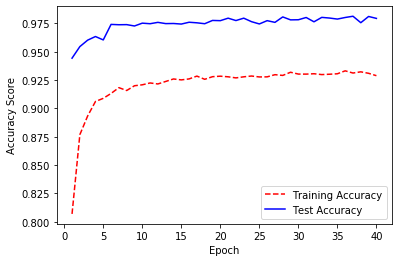

In [12]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
  return round(0.003 * 1/(1 + 0.319 * epoch), 10)

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.003), metrics=['accuracy'])
modelparams = model.fit_generator(X_train_iterator, steps_per_epoch=len(X_train_iterator), epochs=40, verbose=1, validation_data=(X_test_iterator),validation_steps=len(X_test_iterator), callbacks=[LearningRateScheduler(scheduler, verbose=1)])

training_accuracy = modelparams.history['acc']
test_accuracy = modelparams.history['val_acc']
# Create count of the number of epochs
epoch_count = range(1, 41)

# Visualize accuracy history
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, test_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.show();

# fit model with generator
#model.fit_generator(X_train_iterator, steps_per_epoch=len(X_train_iterator), epochs=5)
#model.fit(X_train_iterator, batch_size=128, epochs=20, verbose=1, validation_data=(X_test, Y_test), callbacks=[LearningRateScheduler(scheduler, verbose=1)])


Actually L2 regularisation decreased Acuracy from 99.5 to 99.4 for 20 epoch's
Putting L2 kernel regulariser as 0.0001 The accuracy does not increase but it converges slowly to 99.5 increased to 99.56 for 40 epoch's. Also increases training set , may be we need to write a rate ,l2 regularisation scheduler for each epoch



In [13]:
model.save("session.h5py")
score = model.evaluate_generator(X_test_iterator,steps=len(X_test_iterator),verbose=0)
print(score)

[0.06870258680284023, 0.9795]


(10000, 10)
(10000,) (10000,)
Found 1001 correct labels


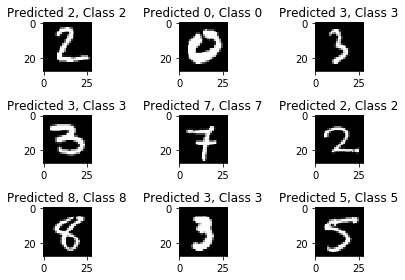

In [14]:
#https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python
#Use this for misclassified images
predicted_classes = model.predict_generator(X_test_iterator,steps = len(X_test_iterator))
print (predicted_classes.shape)
# predictions are floating point values,round off the output which will convert the float values into an integer. np.argmax() 
#to select the index number which has a higher value in a row.
#predIdxs = np.argmax(predIdxs, axis=1)
#predicted_classes = np.round(predicted_classes)
predicted_classes = np.argmax(np.round(predicted_classes),axis=1)
test_classes = np.argmax(np.round(Y_test),axis =1)
print (predicted_classes.shape,test_classes.shape) #, 
correct = np.where(predicted_classes==test_classes)[0]
#print(correct)
print ("Found %d correct labels"%len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], test_classes[correct]))
    plt.tight_layout()

In [15]:
for ilayer, layer in enumerate(model.layers):
    print("{:3.0f} {:10}".format(ilayer, layer.name))

  0 conv2d_1  
  1 batch_normalization_1
  2 dropout_1 
  3 conv2d_2  
  4 batch_normalization_2
  5 dropout_2 
  6 conv2d_3  
  7 max_pooling2d_1
  8 conv2d_4  
  9 batch_normalization_3
 10 dropout_3 
 11 conv2d_5  
 12 batch_normalization_4
 13 dropout_4 
 14 conv2d_6  
 15 batch_normalization_5
 16 dropout_5 
 17 conv2d_7  
 18 batch_normalization_6
 19 dropout_6 
 20 conv2d_8  
 21 batch_normalization_7
 22 dropout_7 
 23 flatten_1 
 24 activation_1


In [16]:
classes = np.unique(y_train)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)


Total number of outputs :  10
Output classes :  [0 1 2 3 4 5 6 7 8 9]


incorrect = np.where(predicted_classes!=test_classes)[0]
print (incorrect.shape)
print ("Found %d incorrect labels" %len(incorrect))
print(size_row)
for i, incorrect in enumerate(incorrect[:30]):
    plt.subplot(3,10,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], test_classes[incorrect]))
    plt.tight_layout()

In [17]:
#img               = img_to_array(_img)
#img               = preprocess_input(img)
classlabel  = ["0","1","2","3","4","5","6","7","8","9"]
#4 images
y_pred_1            = model.predict(X_gradcam_image_1[np.newaxis,...])
class_idxs_sorted_1 = np.argsort(y_pred_1.flatten())[::-1]
topNclass         = 1
for i, idx in enumerate(class_idxs_sorted_1[:topNclass]):
    print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
          i + 1,classlabel[idx],idx,y_pred_1[0,idx]))

y_pred_2            = model.predict(X_gradcam_image_2[np.newaxis,...])
class_idxs_sorted_2 = np.argsort(y_pred_2.flatten())[::-1]
topNclass         = 1
for i, idx in enumerate(class_idxs_sorted_2[:topNclass]):
    print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
          i + 1,classlabel[idx],idx,y_pred_2[0,idx]))

y_pred_3            = model.predict(X_gradcam_image_3[np.newaxis,...])
class_idxs_sorted_3 = np.argsort(y_pred_3.flatten())[::-1]
topNclass         = 1
for i, idx in enumerate(class_idxs_sorted_3[:topNclass]):
    print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
          i + 1,classlabel[idx],idx,y_pred_3[0,idx]))

y_pred_4            = model.predict(X_gradcam_image_4[np.newaxis,...])
class_idxs_sorted_4 = np.argsort(y_pred_4.flatten())[::-1]
topNclass         = 1
for i, idx in enumerate(class_idxs_sorted_4[:topNclass]):
    print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
          i + 1,classlabel[idx],idx,y_pred_4[0,idx]))


Top 1 predicted class:     Pr(Class=2                  [index=2])=0.961
Top 1 predicted class:     Pr(Class=2                  [index=2])=1.000
Top 1 predicted class:     Pr(Class=4                  [index=4])=1.000
Top 1 predicted class:     Pr(Class=8                  [index=8])=1.000


In [0]:
from vis.utils import utils
import keras
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'activation_1')
# Swap softmax with linear
model.layers[layer_idx].activation = keras.activations.linear
model = utils.apply_modifications(model)

In [0]:
from skimage.transform import resize
from vis.visualization import visualize_cam

penultimate_layer_idx = utils.find_layer_idx(model, "conv2d_5") 
class_idx_1  = class_idxs_sorted_1[0]
class_idx_2  = class_idxs_sorted_2[0]
class_idx_3  = class_idxs_sorted_3[0]
class_idx_4  = class_idxs_sorted_4[0]
seed_input_1 = X_gradcam_image_1
seed_input_2 = X_gradcam_image_2
seed_input_3 = X_gradcam_image_3
seed_input_4 = X_gradcam_image_4
grad_top1  = visualize_cam(model, layer_idx, class_idx_1, seed_input_1, 
                           penultimate_layer_idx = penultimate_layer_idx,#None,
                           backprop_modifier     = None,
                           grad_modifier         = None)
grad_top2  = visualize_cam(model, layer_idx, class_idx_2, seed_input_2, 
                           penultimate_layer_idx = penultimate_layer_idx,#None,
                           backprop_modifier     = None,
                           grad_modifier         = None)
grad_top3  = visualize_cam(model, layer_idx, class_idx_3, seed_input_3, 
                           penultimate_layer_idx = penultimate_layer_idx,#None,
                           backprop_modifier     = None,
                           grad_modifier         = None)
grad_top4  = visualize_cam(model, layer_idx, class_idx_4, seed_input_4, 
                           penultimate_layer_idx = penultimate_layer_idx,#None,
                           backprop_modifier     = None,
                           grad_modifier         = None)

WIthout Cutout using Gradcam

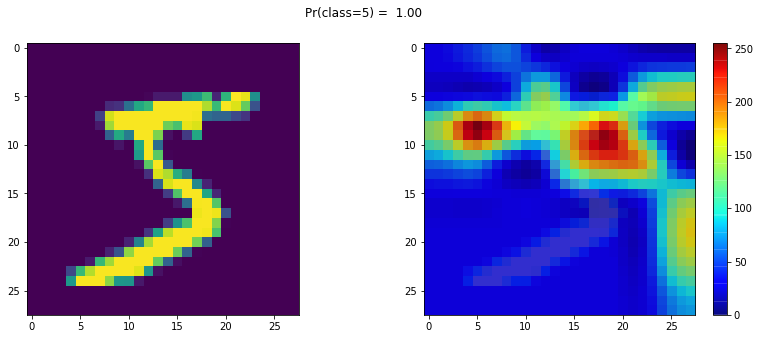

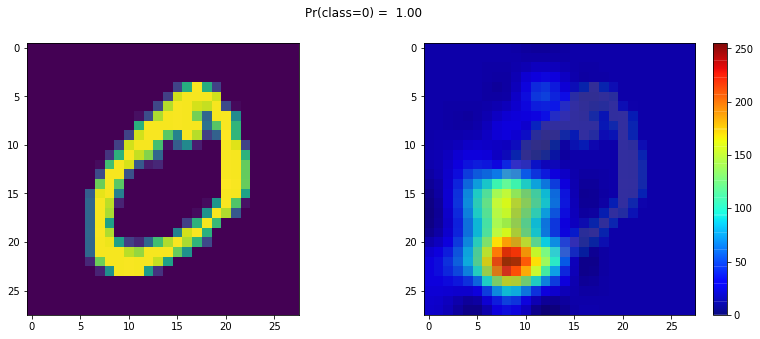

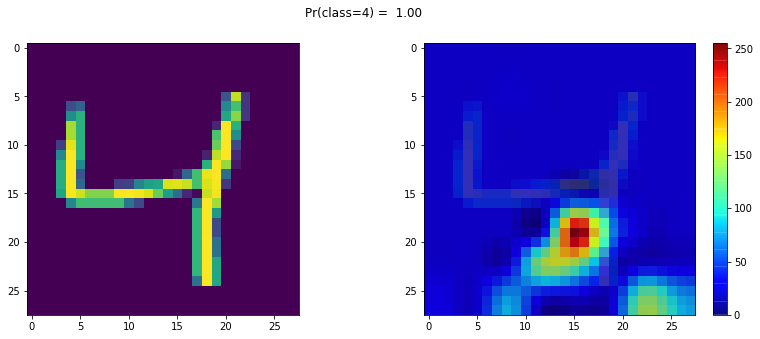

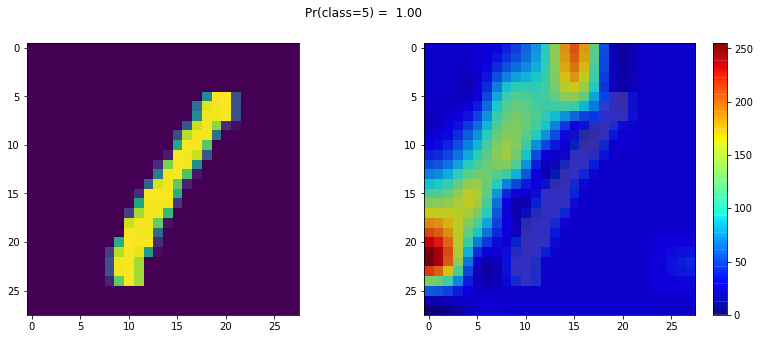

In [33]:
def plot_map(grads,_img,class_idx,y_pred):
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(_img)
    axes[1].imshow(_img)
    i = axes[1].imshow(grads,cmap="jet",alpha=0.8)
    fig.colorbar(i)
    plt.suptitle("Pr(class={}) = {:5.2f}".format(
                      classlabel[class_idx],
                      y_pred[0,class_idx]))
plot_map(grad_top1,X_gradcam_image_1[:,:,0],class_idx_1,y_pred_1)
plot_map(grad_top2,X_gradcam_image_2[:,:,0],class_idx_2,y_pred_2)
plot_map(grad_top3,X_gradcam_image_3[:,:,0],class_idx_3,y_pred_3)
plot_map(grad_top4,X_gradcam_image_4[:,:,0],class_idx_4,y_pred_4)

Images with Cutout and GradCam
Adding cutout made the heat map more normalize towards the entire image which results in better generalisation of dataset

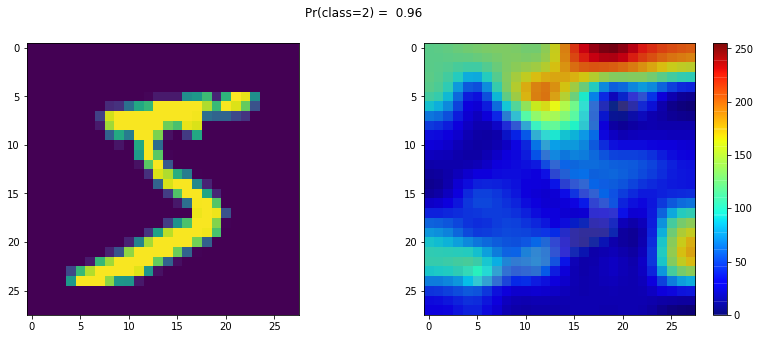

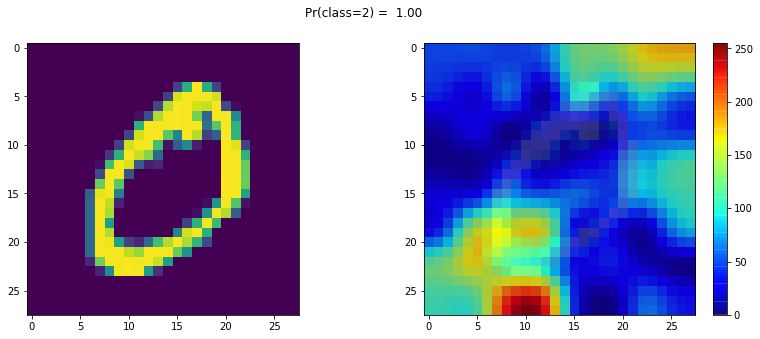

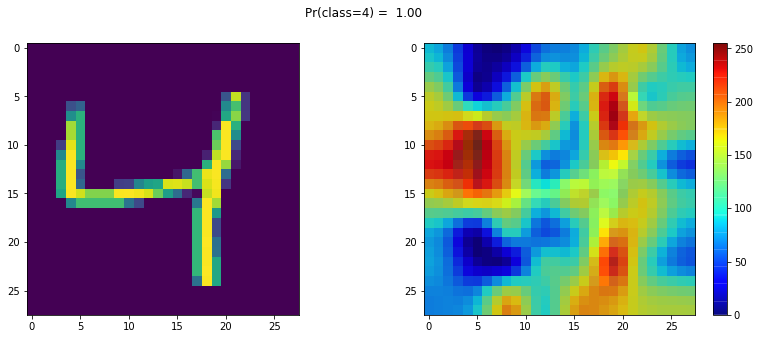

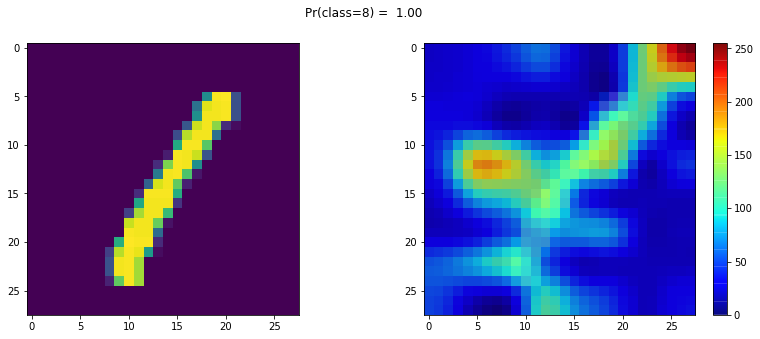

In [21]:
def plot_map(grads,_img,class_idx,y_pred):
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(_img)
    axes[1].imshow(_img)
    i = axes[1].imshow(grads,cmap="jet",alpha=0.8)
    fig.colorbar(i)
    plt.suptitle("Pr(class={}) = {:5.2f}".format(
                      classlabel[class_idx],
                      y_pred[0,class_idx]))
plot_map(grad_top1,X_gradcam_image_1[:,:,0],class_idx_1,y_pred_1)
plot_map(grad_top2,X_gradcam_image_2[:,:,0],class_idx_2,y_pred_2)
plot_map(grad_top3,X_gradcam_image_3[:,:,0],class_idx_3,y_pred_3)
plot_map(grad_top4,X_gradcam_image_4[:,:,0],class_idx_4,y_pred_4)